In [ ]:
# Step 1: Indicating the imported packages/libraries
# import of required libraries and packages
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import time




**Load EMNIST "Balanced" dataset from CSV files**

In [ ]:

# Step 2 Load the downloaded dataset
# Loading EMNIST "Balanced" dataset from CSV files
train_df = pd.read_csv("emnist-balanced-train.csv", header=None)
test_df = pd.read_csv("emnist-balanced-test.csv", header=None)

# Extracting features (images) and labels from the dataframes
X_train_full = train_df.iloc[:, 1:].values.astype('float32') / 255.0
y_train_full = train_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values.astype('float32') / 255.0
y_test = test_df.iloc[:, 0].values

# Reshaping the images
X_train_full = X_train_full.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Binarizing the labels
label_binarizer = LabelBinarizer()
y_train_full = label_binarizer.fit_transform(y_train_full)
y_test = label_binarizer.transform(y_test)

# Loading mapping text file to get class labels
with open("emnist-balanced-mapping.txt", "r") as file:
    mapping = file.readlines()

# Extracting class labels from mapping file
labels = [chr(int(line.split()[1])) for line in mapping]

# Setting a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Step 3: Split data into a training dataset and a testing dataset 
# Splitting the training set into training and validation sets using stratified splitting
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify=y_train_full
)

# Understand the dataset and visualize the dataset: Print-out the number of training/testing samples in the dataset.
 
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of testing samples: {len(X_test)}")



Number of training samples: 101520
Number of validation samples: 11280
Number of testing samples: 18800


**Step 4 : Visualising the Samples Plotting some figures to visualize some samples**

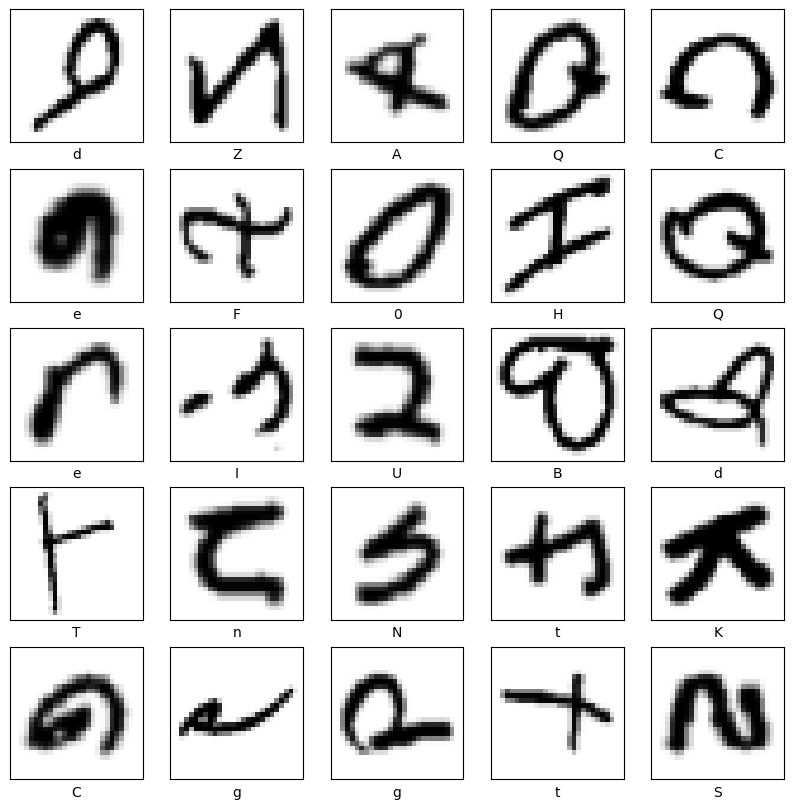

In [ ]:

# Visualizing some samples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i].argmax()])
plt.show()

**Defining MLP Model**

In [ ]:
# Step 5: Function defining MLP model
def create_mlp(num_classes, activation, regularizer, use_dropout, use_batch_norm):
    model = models.Sequential()
    model.add(layers.Reshape((784,), input_shape=(28, 28, 1)))

    model.add(layers.Dense(512, activation=activation, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512, activation=activation, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256, activation=activation, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation=activation, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))
    return model



In [ ]:
# Exploring learning rate scheduling methods
def lr_scheduler_exp(epoch):
    return 1e-3 * (0.9 ** epoch)

def lr_scheduler_step(epoch):
    if epoch < 10:
        return 1e-3
    elif epoch < 15:
        return 1e-4
    else:
        return 1e-5

# Exploring activation functions
activations = ['relu', 'elu', 'leaky_relu']

# Exploring the optimizers
optimizers_list = [
    tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
    tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-3),
    tf.keras.optimizers.legacy.SGD(learning_rate=1e-3)
]

# Exploring the regularization techniques
regularizers_list = [None, regularizers.l1(0.0001), regularizers.l2(0.0005)]



**Training and Evaluation **


In [ ]:
# Step 5 Function for Training and Evaluation of both Models
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, lr_scheduler_func, epochs, batch_size):
    # Compiles the model with specified optimizer, loss, and metrics
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Creating a learning rate scheduler callback
    callbacks = []
    if lr_scheduler_func:
        lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_func)
        callbacks.append(lr_scheduler)

    # Adding early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    callbacks.append(early_stopping)

    # Training the model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Plotting loss and accuracy graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluating the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')
    y_pred = model.predict(X_test[:6])
    print("Predictions for top 6 samples in the test set:")
    for i in range(6):
        print(f"True label: {labels[y_test[i].argmax()]}, Predicted label: {labels[y_pred[i].argmax()]}")

    # Plotting the confusion matrix
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, cmap='Blues')
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculating precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    return history



In [ ]:
# Defines input shape and number of classes
input_shape = (28, 28, 1)
num_classes = len(labels)


Training MLP model:

Combination 1: lr_scheduler=<function lr_scheduler_exp at 0x7ed045f14550>, activation=relu, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x7ed045edb9d0>, regularizer=<keras.src.regularizers.L1 object at 0x7ed045edb970>, use_dropout=True, use_batch_norm=True

Fold 1:
Epoch 1/100
529/529 [==============================] - 9s 14ms/step - loss: 4.1321 - accuracy: 0.5560 - val_loss: 2.9591 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 7s 14ms/step - loss: 2.8215 - accuracy: 0.7106 - val_loss: 2.3101 - val_accuracy: 0.7796 - lr: 9.0000e-04
Epoch 3/100
529/529 [==============================] - 7s 14ms/step - loss: 2.2849 - accuracy: 0.7409 - val_loss: 1.9393 - val_accuracy: 0.7970 - lr: 8.1000e-04
Epoch 4/100
529/529 [==============================] - 7s 14ms/step - loss: 1.9639 - accuracy: 0.7568 - val_loss: 1.7205 - val_accuracy: 0.8004 - lr: 7.2900e-04
Epoch 5/100
529/529 [==============================] - 7s 

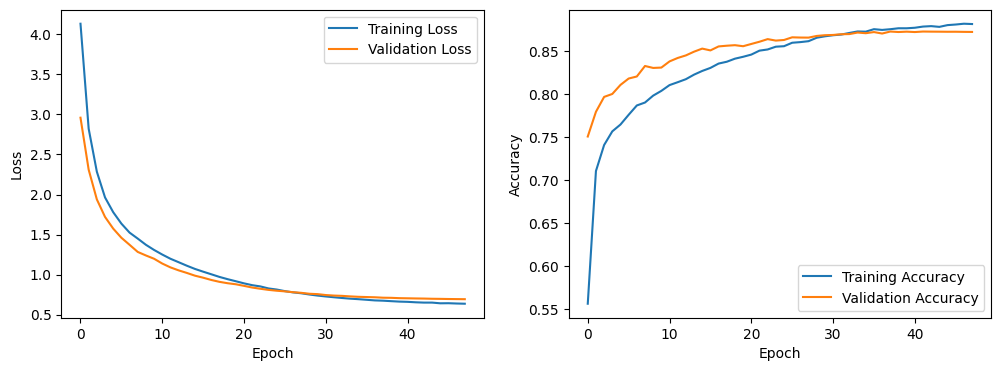

588/588 [==============================] - 2s 3ms/step - loss: 0.7332 - accuracy: 0.8673
Test accuracy: 0.8672872185707092
1/1 [==============================] - 0s 154ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 1s 2ms/step


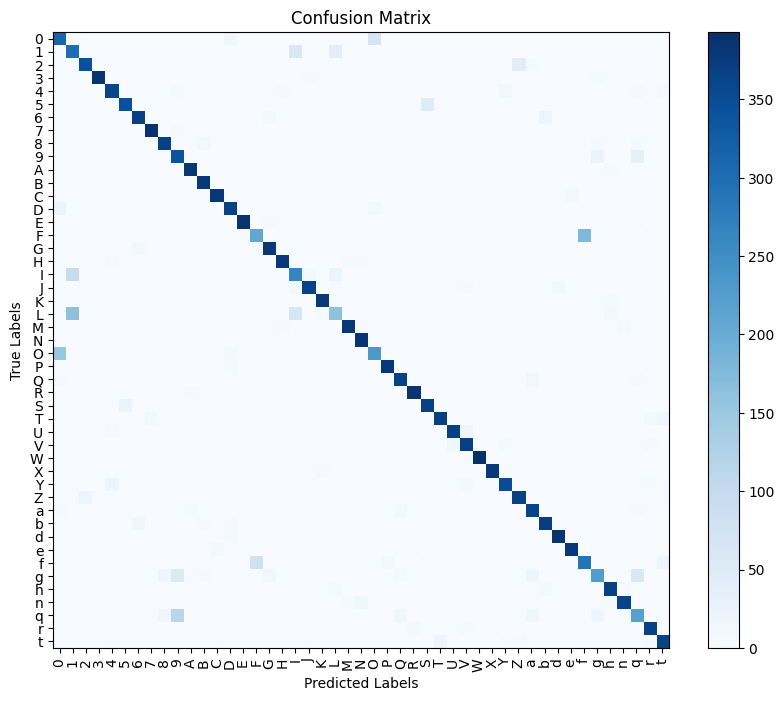

Precision: 0.8695, Recall: 0.8673, F1-score: 0.8658
1058/1058 [==============================] - 3s 3ms/step - loss: 0.7120 - accuracy: 0.8731
Validation Accuracy: 0.8731

Fold 2:
Epoch 1/100
529/529 [==============================] - 9s 15ms/step - loss: 4.1448 - accuracy: 0.5500 - val_loss: 2.9862 - val_accuracy: 0.7427 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 7s 14ms/step - loss: 2.8340 - accuracy: 0.7062 - val_loss: 2.3129 - val_accuracy: 0.7840 - lr: 9.0000e-04
Epoch 3/100
529/529 [==============================] - 7s 14ms/step - loss: 2.2873 - accuracy: 0.7369 - val_loss: 1.9338 - val_accuracy: 0.7979 - lr: 8.1000e-04
Epoch 4/100
529/529 [==============================] - 7s 14ms/step - loss: 1.9656 - accuracy: 0.7560 - val_loss: 1.7097 - val_accuracy: 0.8058 - lr: 7.2900e-04
Epoch 5/100
529/529 [==============================] - 7s 14ms/step - loss: 1.7733 - accuracy: 0.7638 - val_loss: 1.5625 - val_accuracy: 0.8112 - lr: 6.5610e-04
Epoch 6/100
529/529

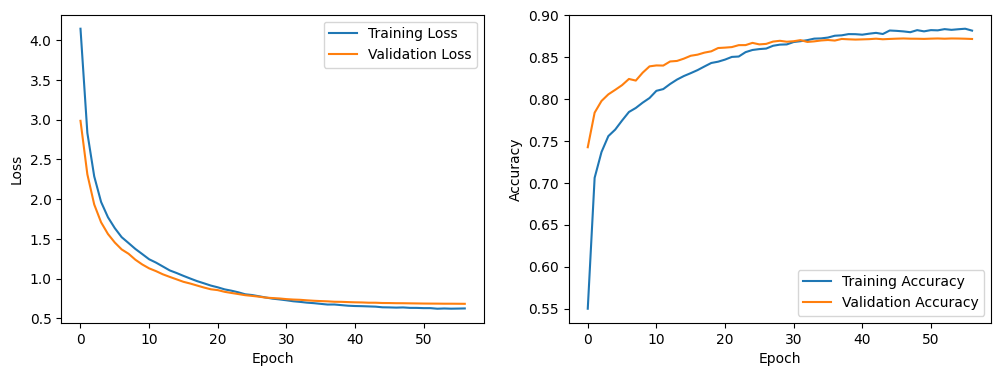

588/588 [==============================] - 1s 2ms/step - loss: 0.7086 - accuracy: 0.8699
Test accuracy: 0.8698936104774475
1/1 [==============================] - 0s 128ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 1s 2ms/step


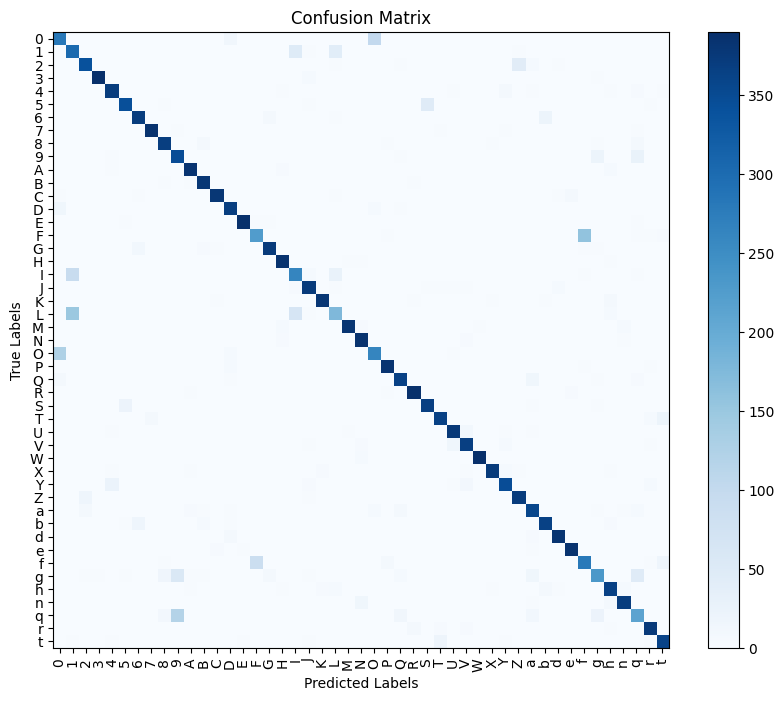

Precision: 0.8713, Recall: 0.8699, F1-score: 0.8686
1058/1058 [==============================] - 3s 2ms/step - loss: 0.6916 - accuracy: 0.8725
Validation Accuracy: 0.8725

Fold 3:
Epoch 1/100
529/529 [==============================] - 9s 15ms/step - loss: 4.1119 - accuracy: 0.5556 - val_loss: 2.9394 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 7s 14ms/step - loss: 2.8156 - accuracy: 0.7068 - val_loss: 2.2966 - val_accuracy: 0.7829 - lr: 9.0000e-04
Epoch 3/100
529/529 [==============================] - 7s 14ms/step - loss: 2.2738 - accuracy: 0.7367 - val_loss: 1.9262 - val_accuracy: 0.7928 - lr: 8.1000e-04
Epoch 4/100
529/529 [==============================] - 7s 14ms/step - loss: 1.9541 - accuracy: 0.7538 - val_loss: 1.7155 - val_accuracy: 0.8025 - lr: 7.2900e-04
Epoch 5/100
529/529 [==============================] - 7s 14ms/step - loss: 1.7648 - accuracy: 0.7658 - val_loss: 1.5582 - val_accuracy: 0.8048 - lr: 6.5610e-04
Epoch 6/100
529/529

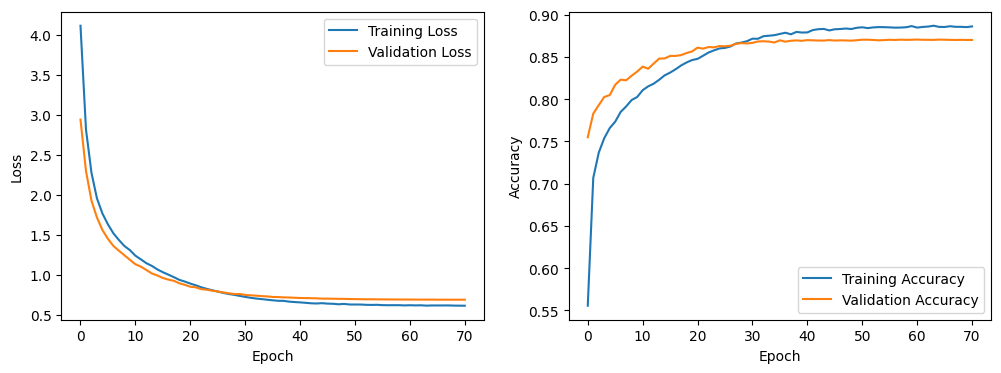

588/588 [==============================] - 1s 2ms/step - loss: 0.7112 - accuracy: 0.8674
Test accuracy: 0.8673936128616333
1/1 [==============================] - 0s 127ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 1s 2ms/step


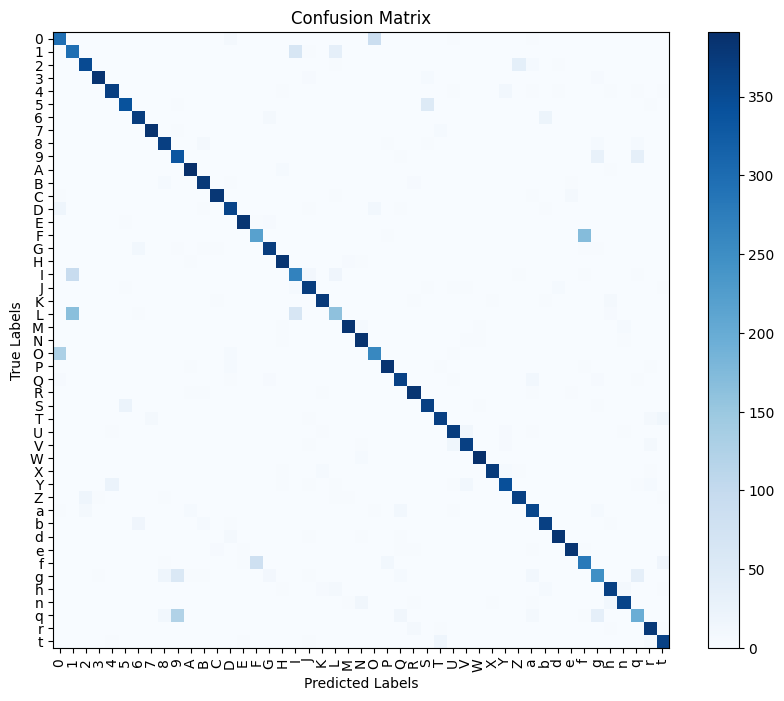

Precision: 0.8691, Recall: 0.8674, F1-score: 0.8658
1058/1058 [==============================] - 3s 2ms/step - loss: 0.6904 - accuracy: 0.8705
Validation Accuracy: 0.8705

Average Validation Accuracy for Combination 1: 0.8720

Combination 2: lr_scheduler=<function lr_scheduler_step at 0x7ed045f167a0>, activation=elu, optimizer=<keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x7ed045edb0d0>, regularizer=<keras.src.regularizers.L2 object at 0x7ed045edaa40>, use_dropout=True, use_batch_norm=True

Fold 1:
Epoch 1/100
529/529 [==============================] - 9s 15ms/step - loss: 2.2185 - accuracy: 0.5650 - val_loss: 1.4627 - val_accuracy: 0.7316 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 7s 14ms/step - loss: 1.5324 - accuracy: 0.6918 - val_loss: 1.1858 - val_accuracy: 0.7717 - lr: 0.0010
Epoch 3/100
529/529 [==============================] - 7s 14ms/step - loss: 1.3126 - accuracy: 0.7231 - val_loss: 1.0398 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 4/100
529

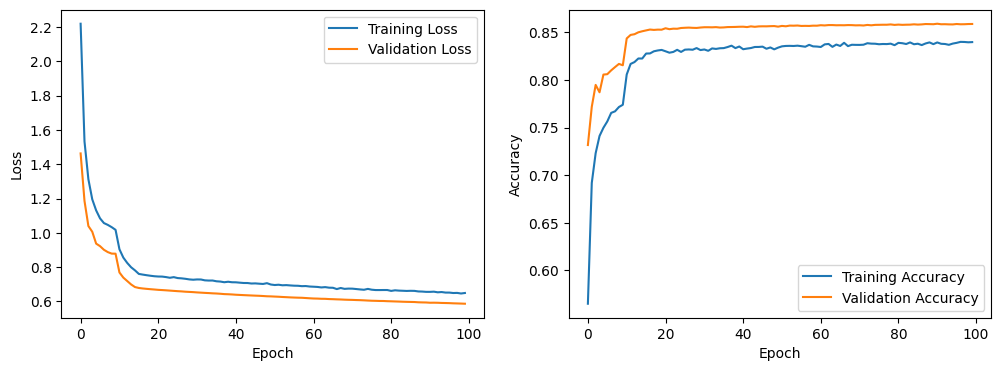

588/588 [==============================] - 2s 3ms/step - loss: 0.6079 - accuracy: 0.8560
Test accuracy: 0.8560106158256531
1/1 [==============================] - 0s 129ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: q
True label: X, Predicted label: X
588/588 [==============================] - 1s 3ms/step


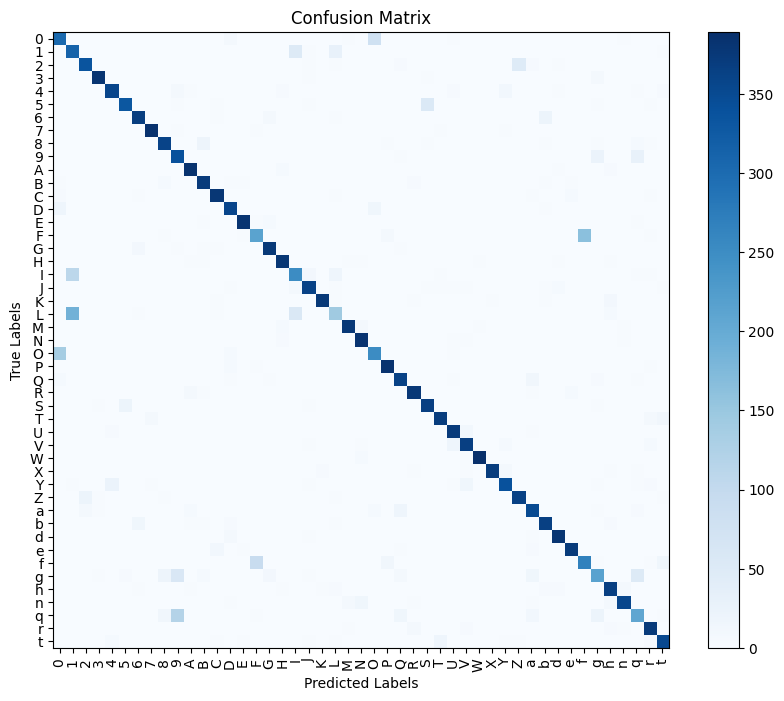

Precision: 0.8586, Recall: 0.8560, F1-score: 0.8542
1058/1058 [==============================] - 3s 3ms/step - loss: 0.5870 - accuracy: 0.8587
Validation Accuracy: 0.8587

Fold 2:
Epoch 1/100
529/529 [==============================] - 9s 15ms/step - loss: 2.2298 - accuracy: 0.5596 - val_loss: 1.4560 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 7s 14ms/step - loss: 1.5455 - accuracy: 0.6892 - val_loss: 1.1815 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 3/100
529/529 [==============================] - 7s 14ms/step - loss: 1.3106 - accuracy: 0.7254 - val_loss: 1.0467 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 4/100
529/529 [==============================] - 7s 14ms/step - loss: 1.1932 - accuracy: 0.7397 - val_loss: 0.9847 - val_accuracy: 0.8002 - lr: 0.0010
Epoch 5/100
529/529 [==============================] - 7s 14ms/step - loss: 1.1221 - accuracy: 0.7538 - val_loss: 0.9374 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 6/100
529/529 [==============

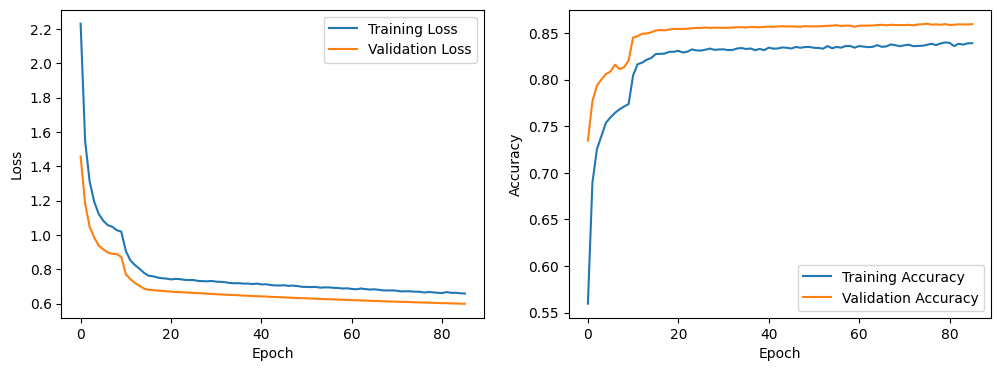

588/588 [==============================] - 2s 3ms/step - loss: 0.6237 - accuracy: 0.8543
Test accuracy: 0.8542553186416626
1/1 [==============================] - 0s 139ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 1s 2ms/step


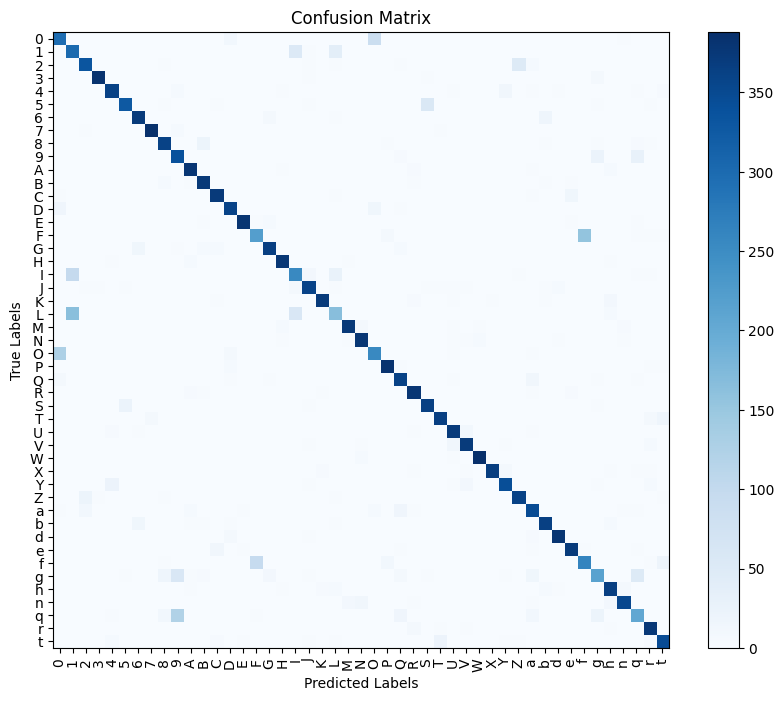

Precision: 0.8558, Recall: 0.8543, F1-score: 0.8527
1058/1058 [==============================] - 3s 3ms/step - loss: 0.6063 - accuracy: 0.8599
Validation Accuracy: 0.8599

Fold 3:
Epoch 1/100
529/529 [==============================] - 9s 15ms/step - loss: 2.2255 - accuracy: 0.5608 - val_loss: 1.4602 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 8s 14ms/step - loss: 1.5354 - accuracy: 0.6913 - val_loss: 1.1747 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 3/100
529/529 [==============================] - 7s 14ms/step - loss: 1.3156 - accuracy: 0.7244 - val_loss: 1.0594 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 4/100
529/529 [==============================] - 7s 14ms/step - loss: 1.1970 - accuracy: 0.7415 - val_loss: 1.0026 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 5/100
529/529 [==============================] - 7s 14ms/step - loss: 1.1255 - accuracy: 0.7544 - val_loss: 0.9357 - val_accuracy: 0.8022 - lr: 0.0010
Epoch 6/100
529/529 [==============

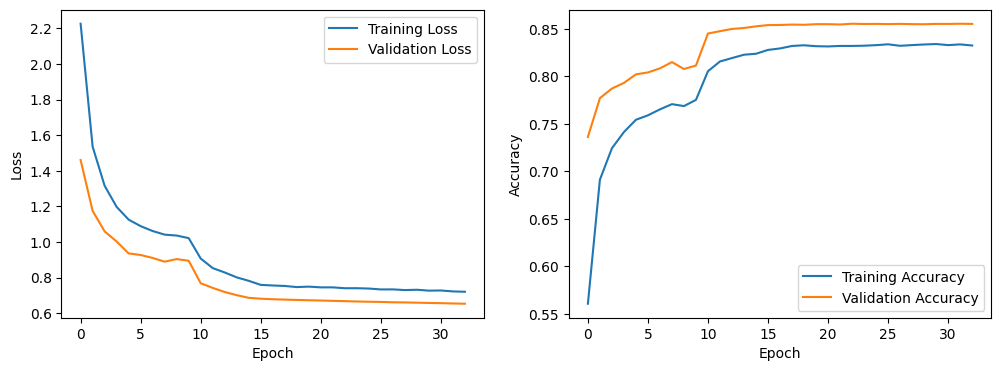

588/588 [==============================] - 2s 3ms/step - loss: 0.6853 - accuracy: 0.8496
Test accuracy: 0.849627673625946
1/1 [==============================] - 0s 133ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 1s 2ms/step


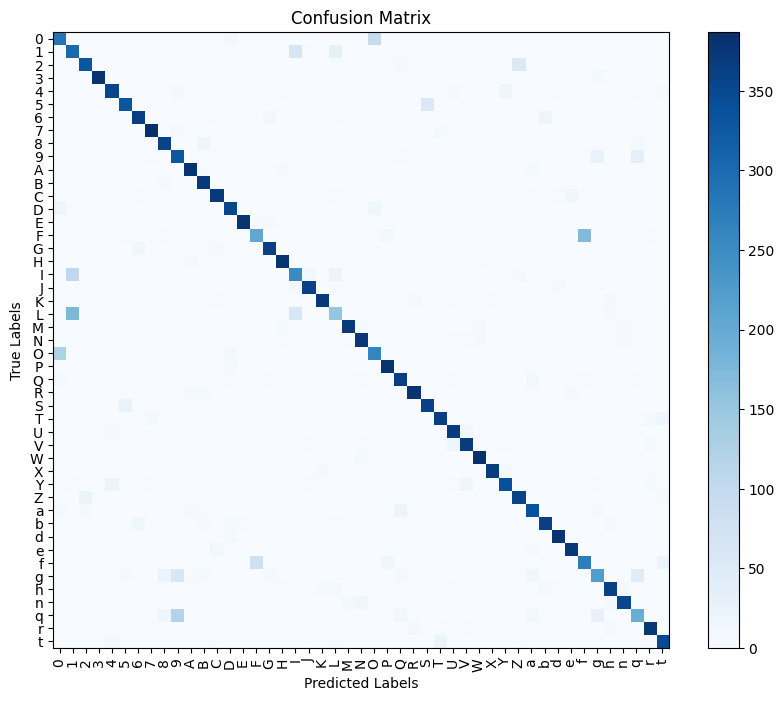

Precision: 0.8511, Recall: 0.8496, F1-score: 0.8478
1058/1058 [==============================] - 3s 3ms/step - loss: 0.6678 - accuracy: 0.8556
Validation Accuracy: 0.8556

Average Validation Accuracy for Combination 2: 0.8581

Best Combination: lr_scheduler=<function lr_scheduler_exp at 0x7ed045f14550>, activation=relu, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x7ed045edb9d0>, regularizer=<keras.src.regularizers.L1 object at 0x7ed045edb970>, use_dropout=True, use_batch_norm=True
Best Validation Accuracy: 0.8720

--- Training Best MLP Model ---
Best Combination: lr_scheduler=<function lr_scheduler_exp at 0x7ed045f14550>, activation=relu, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x7ed045edb9d0>, regularizer=<keras.src.regularizers.L1 object at 0x7ed045edb970>, use_dropout=True, use_batch_norm=True
Epoch 1/100
794/794 [==============================] - 11s 13ms/step - loss: 3.7433 - accuracy: 0.6024 - val_loss: 2.5554 - val_accuracy: 0.7771 - lr: 0.0010

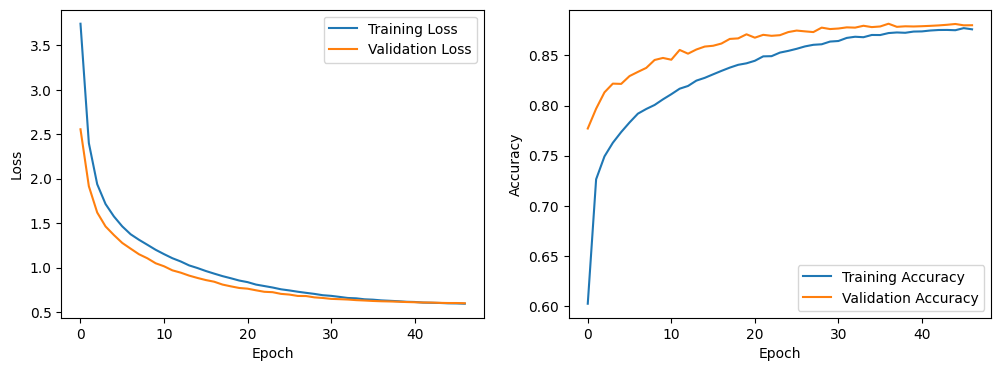

588/588 [==============================] - 2s 3ms/step - loss: 0.6445 - accuracy: 0.8742
Test accuracy: 0.8742021322250366
1/1 [==============================] - 0s 126ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 1s 2ms/step


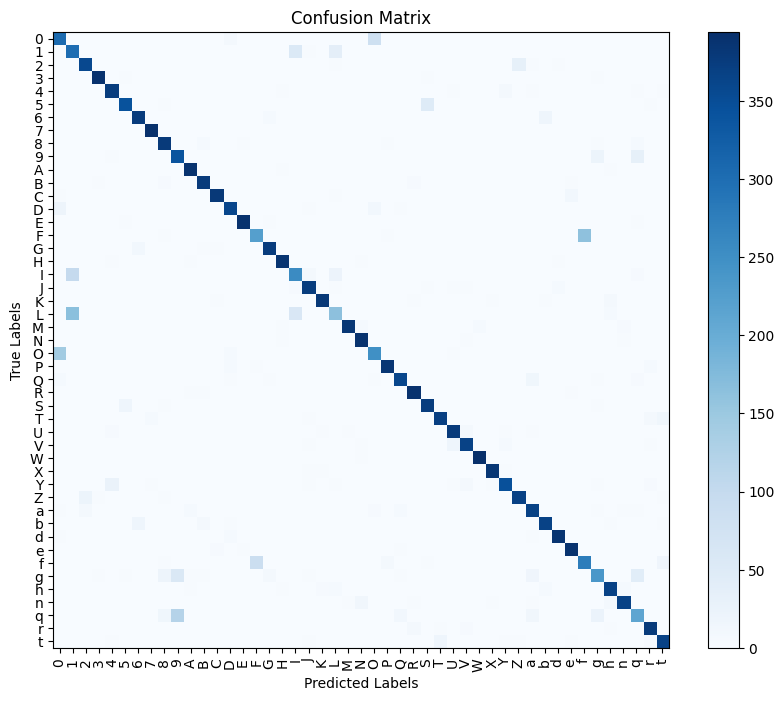

Precision: 0.8762, Recall: 0.8742, F1-score: 0.8727
588/588 [==============================] - 1s 2ms/step

--- Best MLP Model Performance ---
Test Accuracy: 0.8742
Precision: 0.8762
Recall: 0.8742
F1 Score: 0.8727


In [ ]:
# Step 5: Techniques/hyperparameters used and finding best Model
# Creating and training MLP model
print("Training MLP model:")

# Defining the target accuracy threshold
target_accuracy = 0.90

# Defining the list of best combinations to try
promising_combinations = [
    (lr_scheduler_exp, 'relu', optimizers_list[0], regularizers_list[1], True, True),  # Place the desired combination first
    (lr_scheduler_step, 'elu', optimizers_list[1], regularizers_list[2], True, True),
    (None, 'relu', optimizers_list[2], regularizers_list[0], True, False),

]


epochs = 100


max_combinations = 2
promising_combinations = promising_combinations[:max_combinations]

# Creating a text file to store the combination trials, just for reference
with open("combination_trials.txt", "w") as trials_file:
    best_combination = None
    best_accuracy = 0.0

    for combination_count, combination in enumerate(promising_combinations, start=1):
        lr_scheduler, activation, optimizer, regularizer, use_dropout, use_batch_norm = combination
        print(f"\nCombination {combination_count}: lr_scheduler={lr_scheduler}, activation={activation}, optimizer={optimizer}, regularizer={regularizer}, use_dropout={use_dropout}, use_batch_norm={use_batch_norm}")

        fold_accuracies = []
        for fold, (train_idx, val_idx) in enumerate(StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_train, np.argmax(y_train, axis=1)), start=1):
            print(f"\nFold {fold}:")
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            mlp_model_fold = create_mlp(num_classes, activation, regularizer, use_dropout, use_batch_norm)
            train_and_evaluate(mlp_model_fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, X_test, y_test, lr_scheduler, epochs=epochs, batch_size=128)
            _, val_acc = mlp_model_fold.evaluate(X_val_fold, y_val_fold)
            fold_accuracies.append(val_acc)
            print(f"Validation Accuracy: {val_acc:.4f}")

        mlp_acc = np.mean(fold_accuracies)
        print(f"\nAverage Validation Accuracy for Combination {combination_count}: {mlp_acc:.4f}")

        # Writing the combination trial to the text file
        trials_file.write(f"Combination {combination_count}: lr_scheduler={lr_scheduler}, activation={activation}, optimizer={optimizer}, regularizer={regularizer}, use_dropout={use_dropout}, use_batch_norm={use_batch_norm}\n")
        trials_file.write(f"Average Validation Accuracy: {mlp_acc:.4f}\n")
        trials_file.write(f"Fold Accuracies: {fold_accuracies}\n\n")

        # Updating the best combination if the current combination has a higher accuracy
        if mlp_acc > best_accuracy:
            best_combination = combination
            best_accuracy = mlp_acc

    print(f"\nBest Combination: lr_scheduler={best_combination[0]}, activation={best_combination[1]}, optimizer={best_combination[2]}, regularizer={best_combination[3]}, use_dropout={best_combination[4]}, use_batch_norm={best_combination[5]}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Training the final model using the best combination we got
lr_scheduler, activation, optimizer, regularizer, use_dropout, use_batch_norm = best_combination
mlp_model = create_mlp(num_classes, activation, regularizer, use_dropout, use_batch_norm)

print("\n--- Training Best MLP Model ---")
print(f"Best Combination: lr_scheduler={lr_scheduler}, activation={activation}, optimizer={optimizer}, regularizer={regularizer}, use_dropout={use_dropout}, use_batch_norm={use_batch_norm}")

history = train_and_evaluate(mlp_model, X_train, y_train, X_val, y_val, X_test, y_test, lr_scheduler, epochs=epochs, batch_size=128)

# Step 5 to evaluate on the test dataset
# Evaluating the best model on the test set
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(mlp_model.predict(X_test), axis=1)

accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)[1]
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

print("\n--- Best MLP Model Performance ---")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")




--- Best MLP Model Configuration ---
Technique/Metric          Value               
---------------------------------------------
Learning Rate Scheduler   lr_scheduler_exp    
Activation Function       relu                
Optimizer                 <keras.src.optimizers.legacy.adam.Adam object at 0x7bc302946c80>
Regularizer               <keras.src.regularizers.L1 object at 0x7bc302946e60>
Use Dropout               1                   
Use Batch Normalization   1                   
Test Accuracy             0.8707447052001953  
Precision                 0.8722030809995875  
Recall                    0.8707446808510638  
F1 Score                  0.8694114039752383  


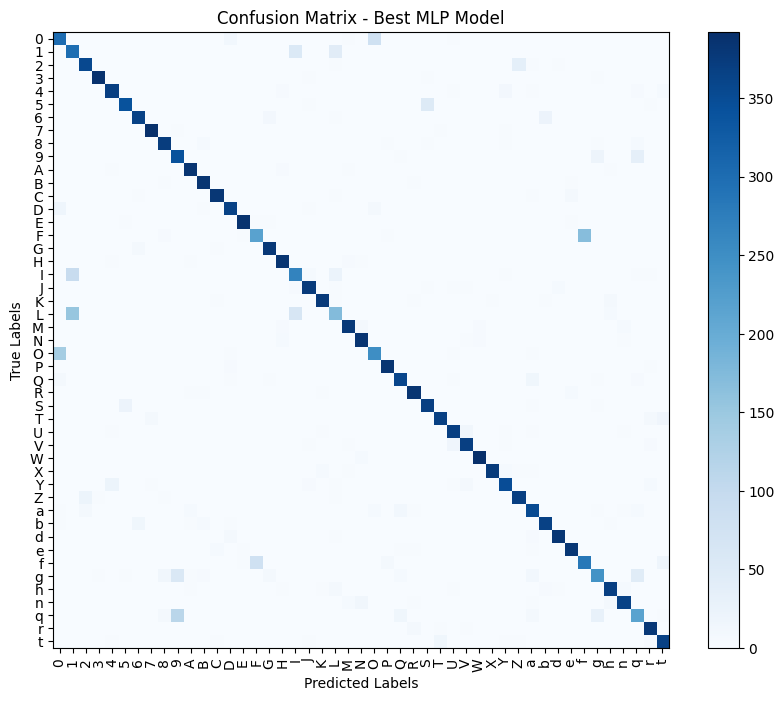

In [ ]:
# Creating a table to summarize the best model's performance
table_data = [
    ["Learning Rate Scheduler", lr_scheduler.__name__ if lr_scheduler else "None"],
    ["Activation Function", activation],
    ["Optimizer", str(optimizer)],
    ["Regularizer", str(regularizer)],
    ["Use Dropout", use_dropout],
    ["Use Batch Normalization", use_batch_norm],
    ["Test Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1 Score", f1]
]

print("\n--- Best MLP Model Configuration ---")
print("{:<25} {:<20}".format("Technique/Metric", "Value"))
print("-" * 45)
for row in table_data:
    print("{:<25} {:<20}".format(row[0], row[1]))

# Plotting the confusion matrix for the best model
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Best MLP Model')
plt.show()

**Training and Evaluation of CNN Model**

In [ ]:
# Step 5 creating CNN model
# Function defining CNN model
def create_cnn(num_classes, activation, regularizer, use_dropout, use_batch_norm):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if use_dropout:
        model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation=activation))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if use_dropout:
        model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation=activation))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

Training CNN model:

CNN Combination 1: lr_scheduler=<function lr_scheduler_exp at 0x7e456b9b27a0>, activation=relu, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x7e45821d83a0>, regularizer=<keras.src.regularizers.L1 object at 0x7e45821d8190>, use_dropout=True, use_batch_norm=True

Fold 1:
Epoch 1/100
529/529 [==============================] - 18s 32ms/step - loss: 1.8941 - accuracy: 0.5620 - val_loss: 1.8569 - val_accuracy: 0.5328 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 17s 31ms/step - loss: 1.0147 - accuracy: 0.7625 - val_loss: 0.7202 - val_accuracy: 0.8395 - lr: 9.0000e-04
Epoch 3/100
529/529 [==============================] - 17s 31ms/step - loss: 0.8461 - accuracy: 0.7974 - val_loss: 0.6440 - val_accuracy: 0.8527 - lr: 8.1000e-04
Epoch 4/100
529/529 [==============================] - 16s 31ms/step - loss: 0.7608 - accuracy: 0.8143 - val_loss: 0.5883 - val_accuracy: 0.8582 - lr: 7.2900e-04
Epoch 5/100
529/529 [=============================

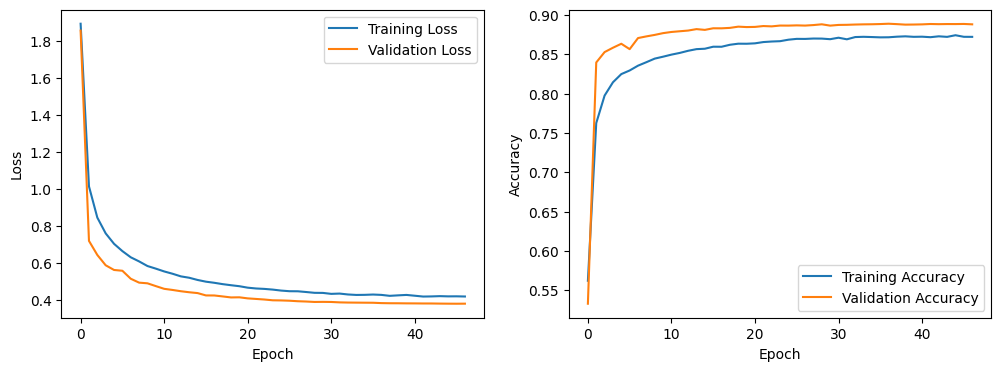

588/588 [==============================] - 2s 4ms/step - loss: 0.4002 - accuracy: 0.8845
Test accuracy: 0.8845213055610657
1/1 [==============================] - 0s 141ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 2s 4ms/step


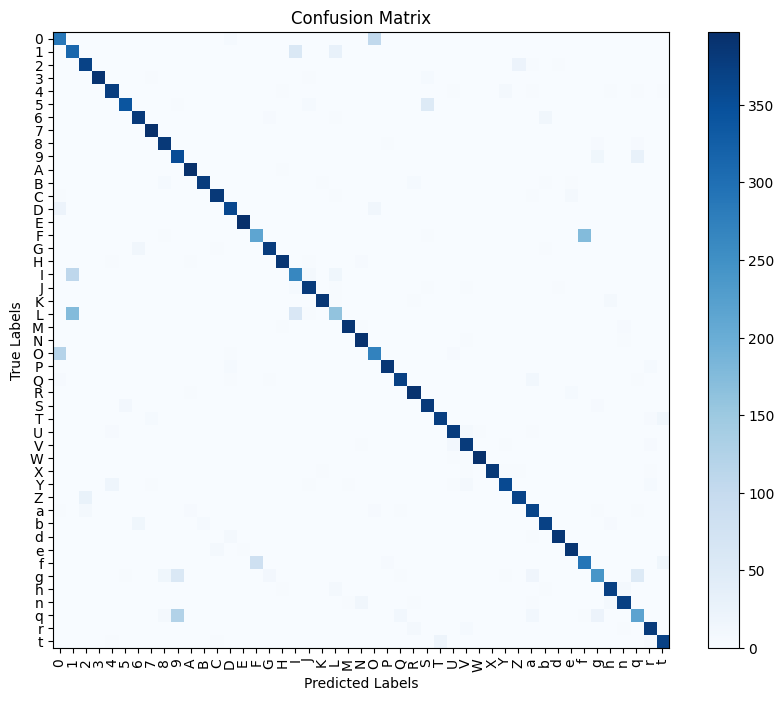

Precision: 0.8879, Recall: 0.8845, F1-score: 0.8832
1058/1058 [==============================] - 4s 4ms/step - loss: 0.3838 - accuracy: 0.8887
Validation Accuracy: 0.8887

Fold 2:
Epoch 1/100
529/529 [==============================] - 18s 32ms/step - loss: 1.9102 - accuracy: 0.5588 - val_loss: 1.9229 - val_accuracy: 0.5236 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 17s 32ms/step - loss: 1.0158 - accuracy: 0.7613 - val_loss: 0.7130 - val_accuracy: 0.8462 - lr: 9.0000e-04
Epoch 3/100
529/529 [==============================] - 17s 32ms/step - loss: 0.8515 - accuracy: 0.7954 - val_loss: 0.6352 - val_accuracy: 0.8558 - lr: 8.1000e-04
Epoch 4/100
529/529 [==============================] - 16s 31ms/step - loss: 0.7635 - accuracy: 0.8123 - val_loss: 0.5826 - val_accuracy: 0.8657 - lr: 7.2900e-04
Epoch 5/100
529/529 [==============================] - 16s 31ms/step - loss: 0.7095 - accuracy: 0.8231 - val_loss: 0.5538 - val_accuracy: 0.8680 - lr: 6.5610e-04
Epoch 6/100
52

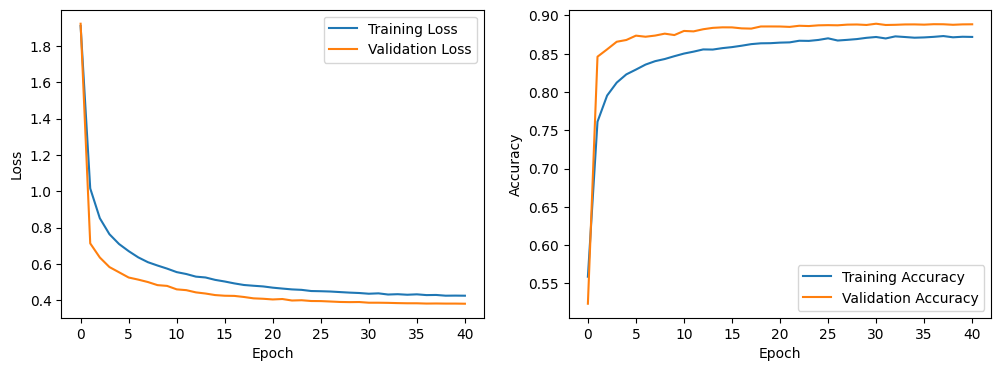

588/588 [==============================] - 2s 4ms/step - loss: 0.4027 - accuracy: 0.8834
Test accuracy: 0.8834042549133301
1/1 [==============================] - 0s 116ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 2s 4ms/step


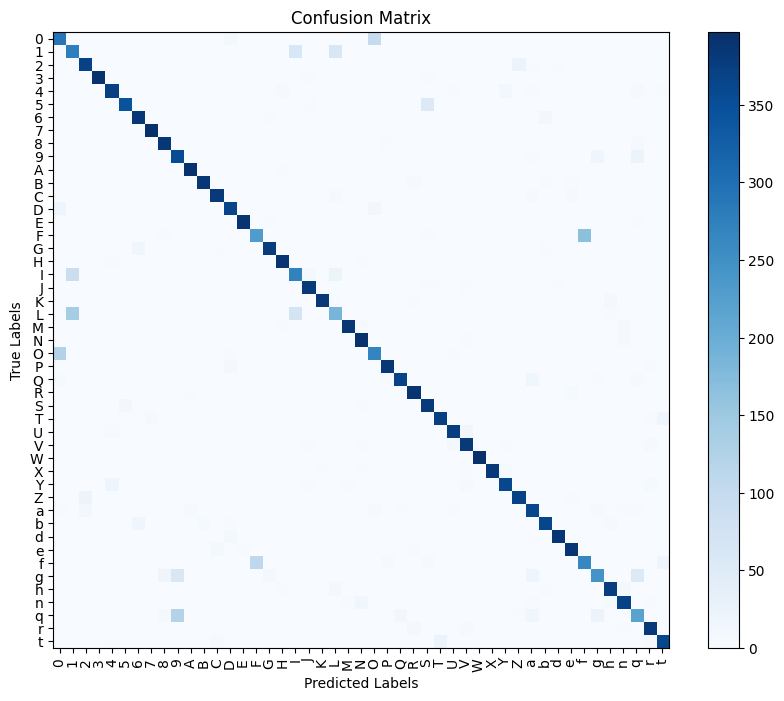

Precision: 0.8851, Recall: 0.8834, F1-score: 0.8824
1058/1058 [==============================] - 4s 4ms/step - loss: 0.3862 - accuracy: 0.8892
Validation Accuracy: 0.8892

Fold 3:
Epoch 1/100
529/529 [==============================] - 17s 31ms/step - loss: 1.8731 - accuracy: 0.5668 - val_loss: 2.0789 - val_accuracy: 0.4644 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 17s 31ms/step - loss: 1.0128 - accuracy: 0.7628 - val_loss: 0.7187 - val_accuracy: 0.8364 - lr: 9.0000e-04
Epoch 3/100
529/529 [==============================] - 17s 32ms/step - loss: 0.8465 - accuracy: 0.7981 - val_loss: 0.6379 - val_accuracy: 0.8520 - lr: 8.1000e-04
Epoch 4/100
529/529 [==============================] - 17s 32ms/step - loss: 0.7541 - accuracy: 0.8180 - val_loss: 0.5867 - val_accuracy: 0.8598 - lr: 7.2900e-04
Epoch 5/100
529/529 [==============================] - 17s 32ms/step - loss: 0.7008 - accuracy: 0.8259 - val_loss: 0.5503 - val_accuracy: 0.8658 - lr: 6.5610e-04
Epoch 6/100
52

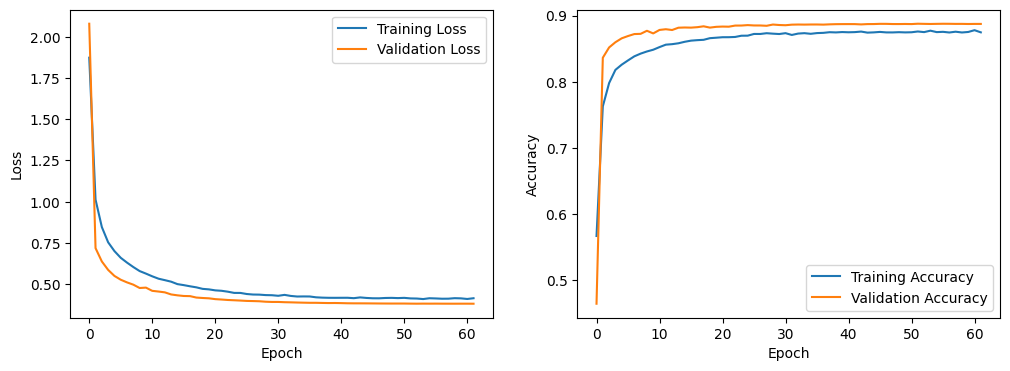

588/588 [==============================] - 2s 4ms/step - loss: 0.3952 - accuracy: 0.8853
Test accuracy: 0.885319173336029
1/1 [==============================] - 0s 115ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 2s 4ms/step


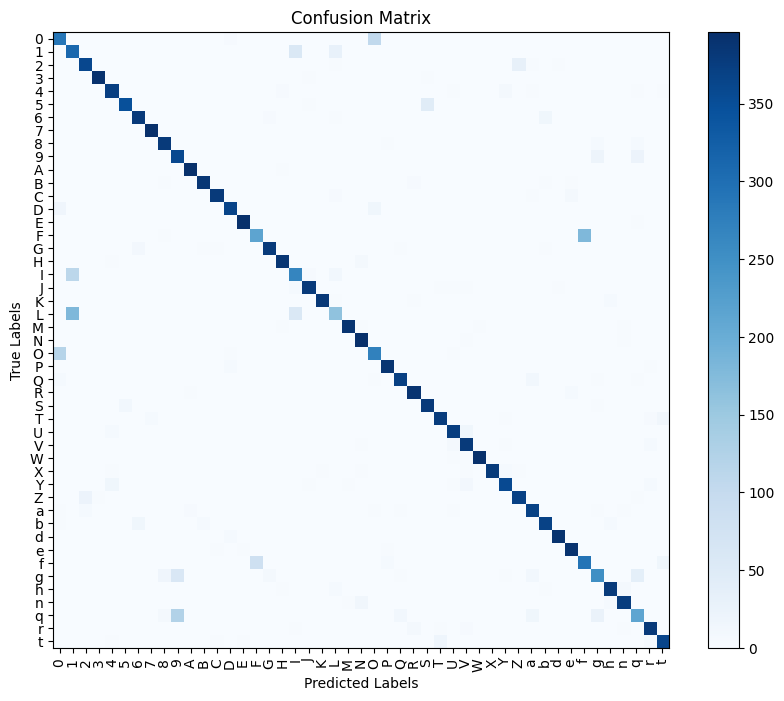

Precision: 0.8890, Recall: 0.8853, F1-score: 0.8841
1058/1058 [==============================] - 4s 4ms/step - loss: 0.3824 - accuracy: 0.8878
Validation Accuracy: 0.8878

Average Validation Accuracy for CNN Combination 1: 0.8886

CNN Combination 2: lr_scheduler=<function lr_scheduler_step at 0x7e456b9b1bd0>, activation=elu, optimizer=<keras.src.optimizers.legacy.rmsprop.RMSprop object at 0x7e45821d9240>, regularizer=<keras.src.regularizers.L2 object at 0x7e45821d9d20>, use_dropout=True, use_batch_norm=True

Fold 1:
Epoch 1/100
529/529 [==============================] - 19s 33ms/step - loss: 1.6211 - accuracy: 0.5701 - val_loss: 2.2773 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 17s 32ms/step - loss: 0.8404 - accuracy: 0.7612 - val_loss: 0.5745 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 3/100
529/529 [==============================] - 17s 33ms/step - loss: 0.7025 - accuracy: 0.7943 - val_loss: 0.5435 - val_accuracy: 0.8410 - lr: 0.0010
Epoc

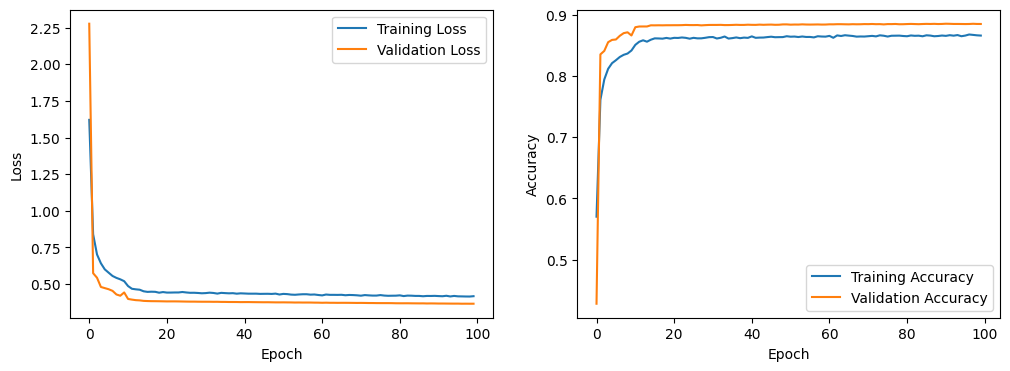

588/588 [==============================] - 3s 4ms/step - loss: 0.3809 - accuracy: 0.8818
Test accuracy: 0.8817552924156189
1/1 [==============================] - 0s 121ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 2s 4ms/step


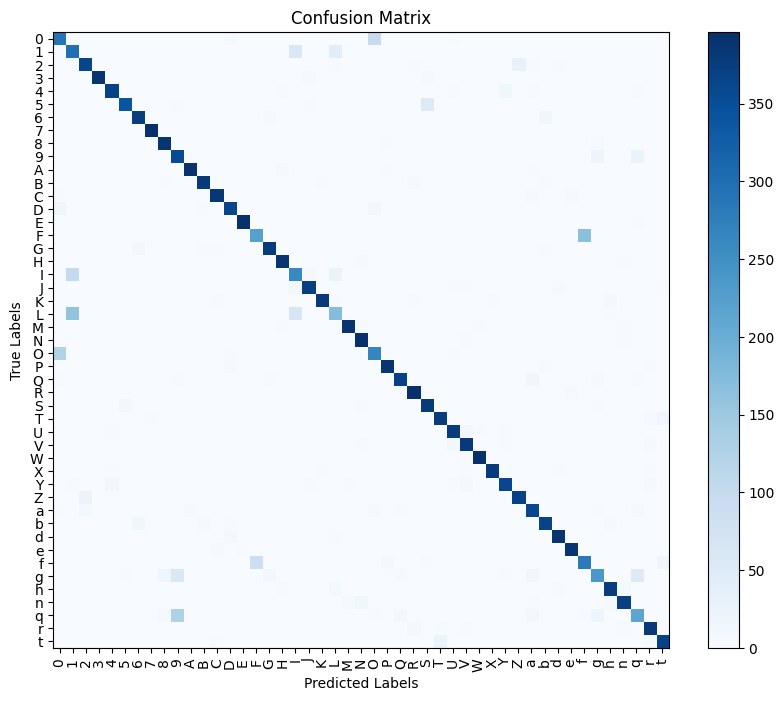

Precision: 0.8841, Recall: 0.8818, F1-score: 0.8806
1058/1058 [==============================] - 5s 4ms/step - loss: 0.3662 - accuracy: 0.8851
Validation Accuracy: 0.8851

Fold 2:
Epoch 1/100
529/529 [==============================] - 18s 33ms/step - loss: 1.6490 - accuracy: 0.5610 - val_loss: 1.4983 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 18s 33ms/step - loss: 0.8416 - accuracy: 0.7601 - val_loss: 0.5563 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 3/100
529/529 [==============================] - 18s 34ms/step - loss: 0.7048 - accuracy: 0.7951 - val_loss: 0.5212 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 4/100
529/529 [==============================] - 17s 32ms/step - loss: 0.6413 - accuracy: 0.8103 - val_loss: 0.4738 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 5/100
529/529 [==============================] - 18s 33ms/step - loss: 0.5996 - accuracy: 0.8213 - val_loss: 0.4524 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 6/100
529/529 [=========

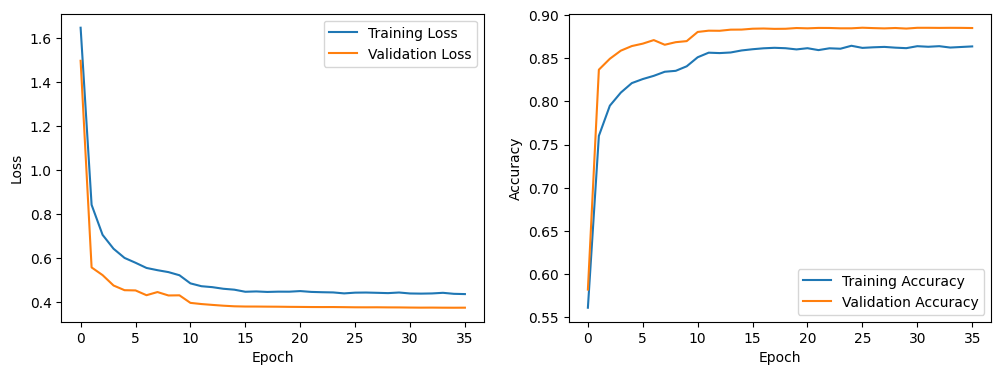

588/588 [==============================] - 3s 4ms/step - loss: 0.3955 - accuracy: 0.8800
Test accuracy: 0.8799999952316284
1/1 [==============================] - 0s 116ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 2s 4ms/step


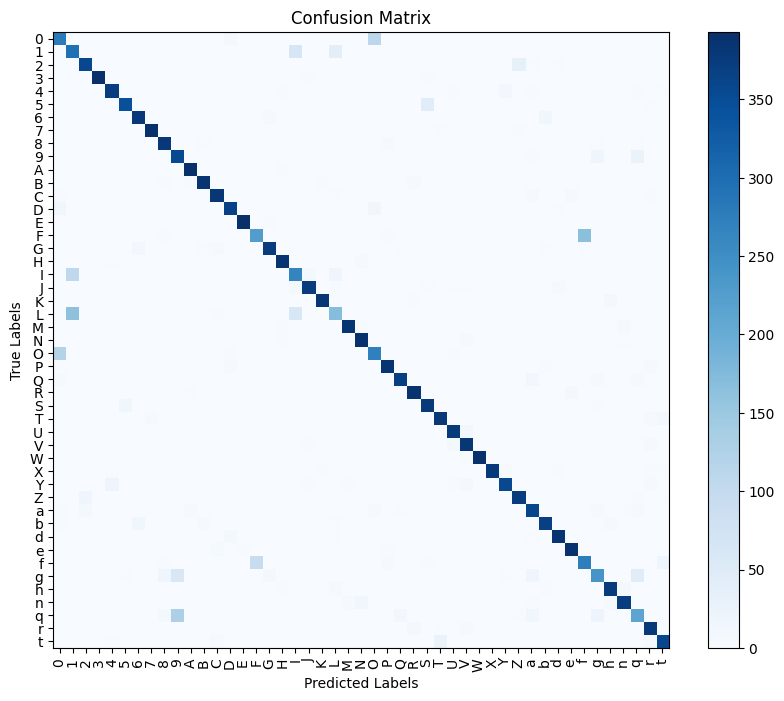

Precision: 0.8825, Recall: 0.8800, F1-score: 0.8788
1058/1058 [==============================] - 5s 4ms/step - loss: 0.3745 - accuracy: 0.8854
Validation Accuracy: 0.8854

Fold 3:
Epoch 1/100
529/529 [==============================] - 19s 34ms/step - loss: 1.6512 - accuracy: 0.5634 - val_loss: 1.5798 - val_accuracy: 0.5621 - lr: 0.0010
Epoch 2/100
529/529 [==============================] - 16s 31ms/step - loss: 0.8505 - accuracy: 0.7563 - val_loss: 0.5989 - val_accuracy: 0.8243 - lr: 0.0010
Epoch 3/100
529/529 [==============================] - 17s 31ms/step - loss: 0.7067 - accuracy: 0.7952 - val_loss: 0.5154 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 4/100
529/529 [==============================] - 17s 32ms/step - loss: 0.6440 - accuracy: 0.8101 - val_loss: 0.4877 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 5/100
529/529 [==============================] - 17s 32ms/step - loss: 0.6050 - accuracy: 0.8188 - val_loss: 0.4608 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 6/100
529/529 [=========

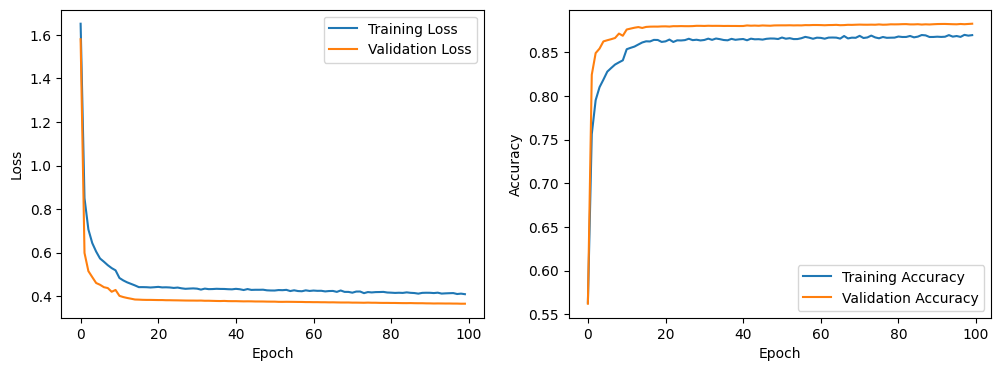

588/588 [==============================] - 3s 4ms/step - loss: 0.3823 - accuracy: 0.8823
Test accuracy: 0.8822872042655945
1/1 [==============================] - 0s 116ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 2s 4ms/step


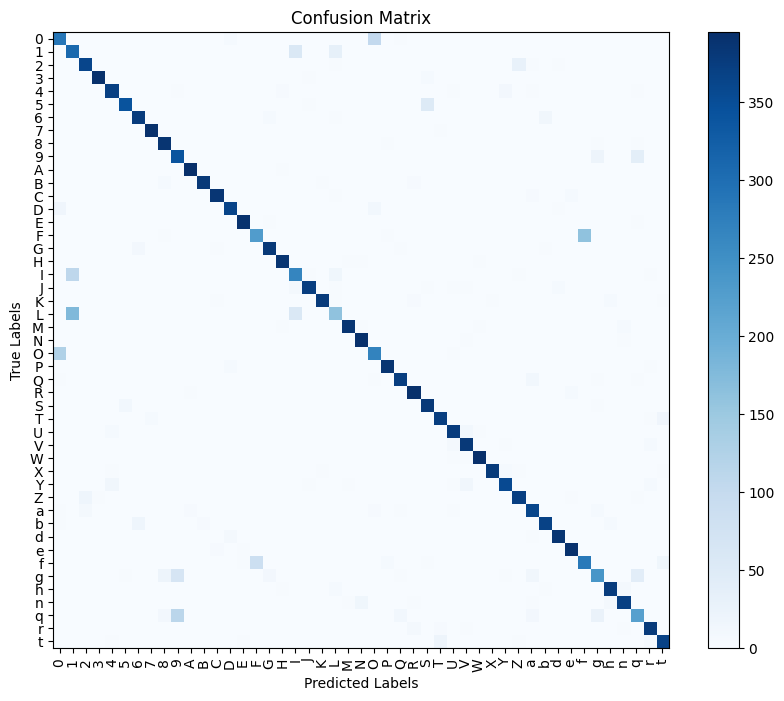

Precision: 0.8851, Recall: 0.8823, F1-score: 0.8812
1058/1058 [==============================] - 5s 4ms/step - loss: 0.3657 - accuracy: 0.8827
Validation Accuracy: 0.8827

Average Validation Accuracy for CNN Combination 2: 0.8844

Best CNN Combination: lr_scheduler=<function lr_scheduler_exp at 0x7e456b9b27a0>, activation=relu, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x7e45821d83a0>, regularizer=<keras.src.regularizers.L1 object at 0x7e45821d8190>, use_dropout=True, use_batch_norm=True
Best CNN Validation Accuracy: 0.8886

--- Training Best CNN Model ---
Best CNN Combination: lr_scheduler=<function lr_scheduler_exp at 0x7e456b9b27a0>, activation=relu, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x7e45821d83a0>, regularizer=<keras.src.regularizers.L1 object at 0x7e45821d8190>, use_dropout=True, use_batch_norm=True
Epoch 1/100
794/794 [==============================] - 24s 29ms/step - loss: 1.6623 - accuracy: 0.6142 - val_loss: 0.8193 - val_accuracy: 0.8

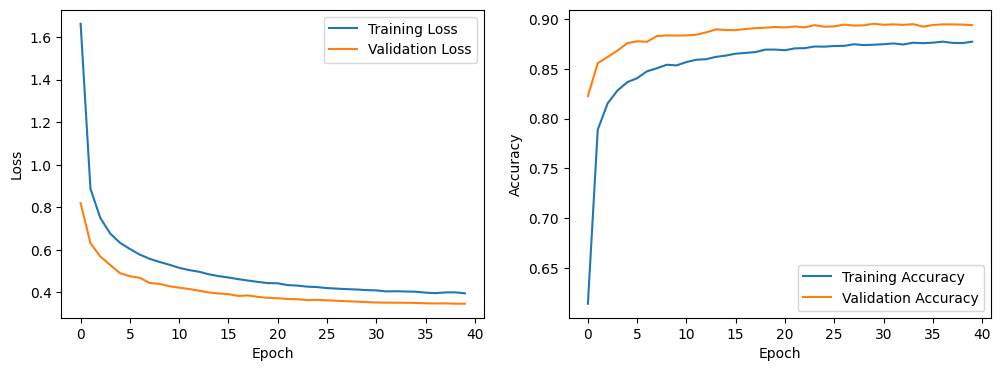

588/588 [==============================] - 2s 4ms/step - loss: 0.3763 - accuracy: 0.8881
Test accuracy: 0.888085126876831
1/1 [==============================] - 0s 121ms/step
Predictions for top 6 samples in the test set:
True label: g, Predicted label: g
True label: e, Predicted label: e
True label: 9, Predicted label: 9
True label: Q, Predicted label: Q
True label: q, Predicted label: 9
True label: X, Predicted label: X
588/588 [==============================] - 2s 4ms/step


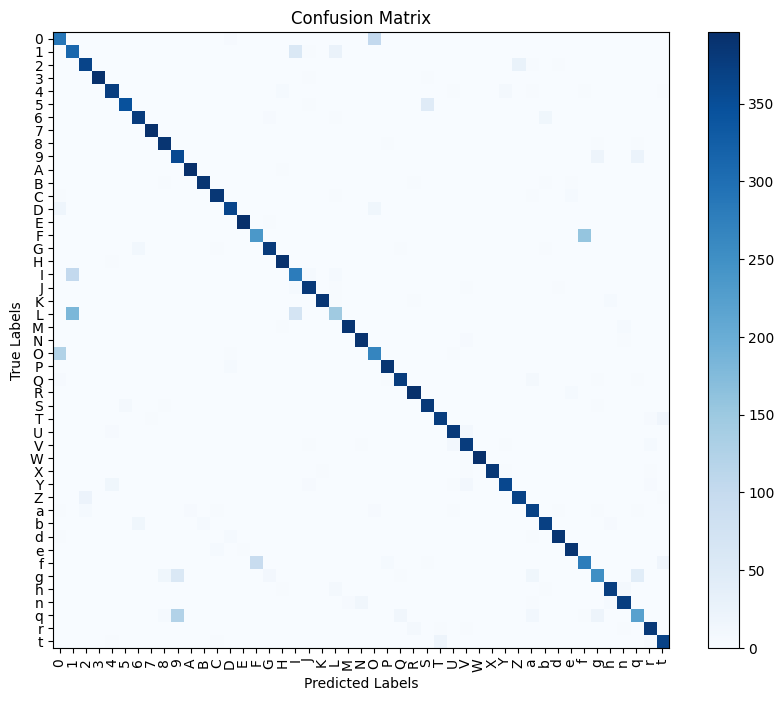

Precision: 0.8916, Recall: 0.8881, F1-score: 0.8867
588/588 [==============================] - 2s 4ms/step

--- Best CNN Model Performance ---
Test Accuracy: 0.8881
Precision: 0.8916
Recall: 0.8881
F1 Score: 0.8867

--- Best CNN Model Configuration ---
Technique/Metric          Value               
---------------------------------------------
Learning Rate Scheduler   lr_scheduler_exp    
Activation Function       relu                
Optimizer                 <keras.src.optimizers.legacy.adam.Adam object at 0x7e45821d83a0>
Regularizer               <keras.src.regularizers.L1 object at 0x7e45821d8190>
Use Dropout               1                   
Use Batch Normalization   1                   
Test Accuracy             0.888085126876831   
Precision                 0.8916378091808366  
Recall                    0.8880851063829788  
F1 Score                  0.8867159306105373  


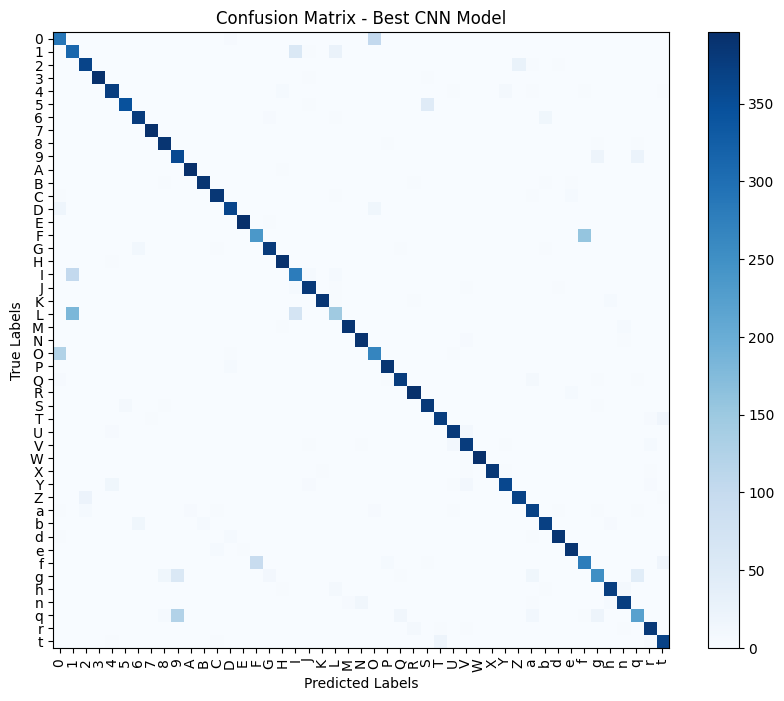

In [ ]:


# Step 5 training and Evaluation of CNN model
print("Training CNN model:")


target_accuracy = 0.90

# Defining a list of best combinations to try for CNN
cnn_promising_combinations = [
    (lr_scheduler_exp, 'relu', optimizers_list[0], regularizers_list[1], True, True),
    (lr_scheduler_step, 'elu', optimizers_list[1], regularizers_list[2], True, True),
    (None, 'relu', optimizers_list[2], regularizers_list[0], True, False),

]


epochs = 100


max_combinations = 2
cnn_promising_combinations = cnn_promising_combinations[:max_combinations]

# Creating a text file to store the combination trials for CNN, just for reference
with open("cnn_combination_trials.txt", "w") as trials_file:
    best_cnn_combination = None
    best_cnn_accuracy = 0.0

    for combination_count, combination in enumerate(cnn_promising_combinations, start=1):
        lr_scheduler, activation, optimizer, regularizer, use_dropout, use_batch_norm = combination
        print(f"\nCNN Combination {combination_count}: lr_scheduler={lr_scheduler}, activation={activation}, optimizer={optimizer}, regularizer={regularizer}, use_dropout={use_dropout}, use_batch_norm={use_batch_norm}")

        fold_accuracies = []
        for fold, (train_idx, val_idx) in enumerate(StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_train, np.argmax(y_train, axis=1)), start=1):
            print(f"\nFold {fold}:")
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            cnn_model_fold = create_cnn(num_classes, activation, regularizer, use_dropout, use_batch_norm)
            train_and_evaluate(cnn_model_fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, X_test, y_test, lr_scheduler, epochs=epochs, batch_size=128)
            _, val_acc = cnn_model_fold.evaluate(X_val_fold, y_val_fold)
            fold_accuracies.append(val_acc)
            print(f"Validation Accuracy: {val_acc:.4f}")

        cnn_acc = np.mean(fold_accuracies)
        print(f"\nAverage Validation Accuracy for CNN Combination {combination_count}: {cnn_acc:.4f}")

        # Writing the combination trial to the text file
        trials_file.write(f"CNN Combination {combination_count}: lr_scheduler={lr_scheduler}, activation={activation}, optimizer={optimizer}, regularizer={regularizer}, use_dropout={use_dropout}, use_batch_norm={use_batch_norm}\n")
        trials_file.write(f"Average Validation Accuracy: {cnn_acc:.4f}\n")
        trials_file.write(f"Fold Accuracies: {fold_accuracies}\n\n")

        # Updating the best combination if the current combination has a higher accuracy
        if cnn_acc > best_cnn_accuracy:
            best_cnn_combination = combination
            best_cnn_accuracy = cnn_acc

    print(f"\nBest CNN Combination: lr_scheduler={best_cnn_combination[0]}, activation={best_cnn_combination[1]}, optimizer={best_cnn_combination[2]}, regularizer={best_cnn_combination[3]}, use_dropout={best_cnn_combination[4]}, use_batch_norm={best_cnn_combination[5]}")
    print(f"Best CNN Validation Accuracy: {best_cnn_accuracy:.4f}")

# Training the final CNN model using the best combination
lr_scheduler, activation, optimizer, regularizer, use_dropout, use_batch_norm = best_cnn_combination
cnn_model = create_cnn(num_classes, activation, regularizer, use_dropout, use_batch_norm)

print("\n--- Training Best CNN Model ---")
print(f"Best CNN Combination: lr_scheduler={lr_scheduler}, activation={activation}, optimizer={optimizer}, regularizer={regularizer}, use_dropout={use_dropout}, use_batch_norm={use_batch_norm}")

history = train_and_evaluate(cnn_model, X_train, y_train, X_val, y_val, X_test, y_test, lr_scheduler, epochs=epochs, batch_size=128)

# Evaluating the best CNN model on the test set
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(cnn_model.predict(X_test), axis=1)

accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)[1]
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

print("\n--- Best CNN Model Performance ---")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Creating a table to summarize the best CNN model's performance
cnn_table_data = [
    ["Learning Rate Scheduler", lr_scheduler.__name__ if lr_scheduler else "None"],
    ["Activation Function", activation],
    ["Optimizer", str(optimizer)],
    ["Regularizer", str(regularizer)],
    ["Use Dropout", use_dropout],
    ["Use Batch Normalization", use_batch_norm],
    ["Test Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1 Score", f1]
]

print("\n--- Best CNN Model Configuration ---")
print("{:<25} {:<20}".format("Technique/Metric", "Value"))
print("-" * 45)
for row in cnn_table_data:
    print("{:<25} {:<20}".format(row[0], row[1]))

# Step 5 Plotting the confusion matrix for the best CNN model
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Best CNN Model')
plt.show()

*** Step 6: Additional validation to compare the MLP and CNN Models performance ***

In [ ]:

# Step 6 Testing on Test data with the best version of MLP and CNNs
# Setting the best combination of hyperparameters and architecture for MLP
mlp_best_combination = (lr_scheduler_exp, 'relu', tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), regularizers.l1(0.0001), True, True)

# Setting the best combination of hyperparameters and architecture for CNN
cnn_best_combination = (lr_scheduler_exp, 'relu', tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), regularizers.l1(0.0001), True, True)

# Creating the MLP model with the best combination
mlp_model = create_mlp(num_classes, mlp_best_combination[1], mlp_best_combination[3], mlp_best_combination[4], mlp_best_combination[5])
mlp_model.compile(optimizer=mlp_best_combination[2], loss='categorical_crossentropy', metrics=['accuracy'])

# Creating the CNN model with the best combination
cnn_model = create_cnn(num_classes, cnn_best_combination[1], cnn_best_combination[3], cnn_best_combination[4], cnn_best_combination[5])
cnn_model.compile(optimizer=cnn_best_combination[2], loss='categorical_crossentropy', metrics=['accuracy'])

# Training the models
mlp_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)

# Evaluating the models on the testing dataset
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)

print("MLP Model - Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(mlp_loss, mlp_accuracy))
print("CNN Model - Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(cnn_loss, cnn_accuracy))

Epoch 1/10
794/794 [==============================] - 11s 13ms/step - loss: 3.7426 - accuracy: 0.5997 - val_loss: 2.5419 - val_accuracy: 0.7809
Epoch 2/10
794/794 [==============================] - 10s 12ms/step - loss: 2.3869 - accuracy: 0.7254 - val_loss: 1.8949 - val_accuracy: 0.7907
Epoch 3/10
794/794 [==============================] - 10s 12ms/step - loss: 1.9661 - accuracy: 0.7416 - val_loss: 1.6618 - val_accuracy: 0.8041
Epoch 4/10
794/794 [==============================] - 10s 12ms/step - loss: 1.7905 - accuracy: 0.7532 - val_loss: 1.5799 - val_accuracy: 0.7988
Epoch 5/10
794/794 [==============================] - 10s 12ms/step - loss: 1.7041 - accuracy: 0.7583 - val_loss: 1.4744 - val_accuracy: 0.8130
Epoch 6/10
794/794 [==============================] - 10s 12ms/step - loss: 1.6333 - accuracy: 0.7654 - val_loss: 1.4490 - val_accuracy: 0.8088
Epoch 7/10
794/794 [==============================] - 10s 12ms/step - loss: 1.5954 - accuracy: 0.7650 - val_loss: 1.3727 - val_accuracy:

1/1 [==============================] - 0s 27ms/step
Predictions for top 6 samples in the testing dataset:


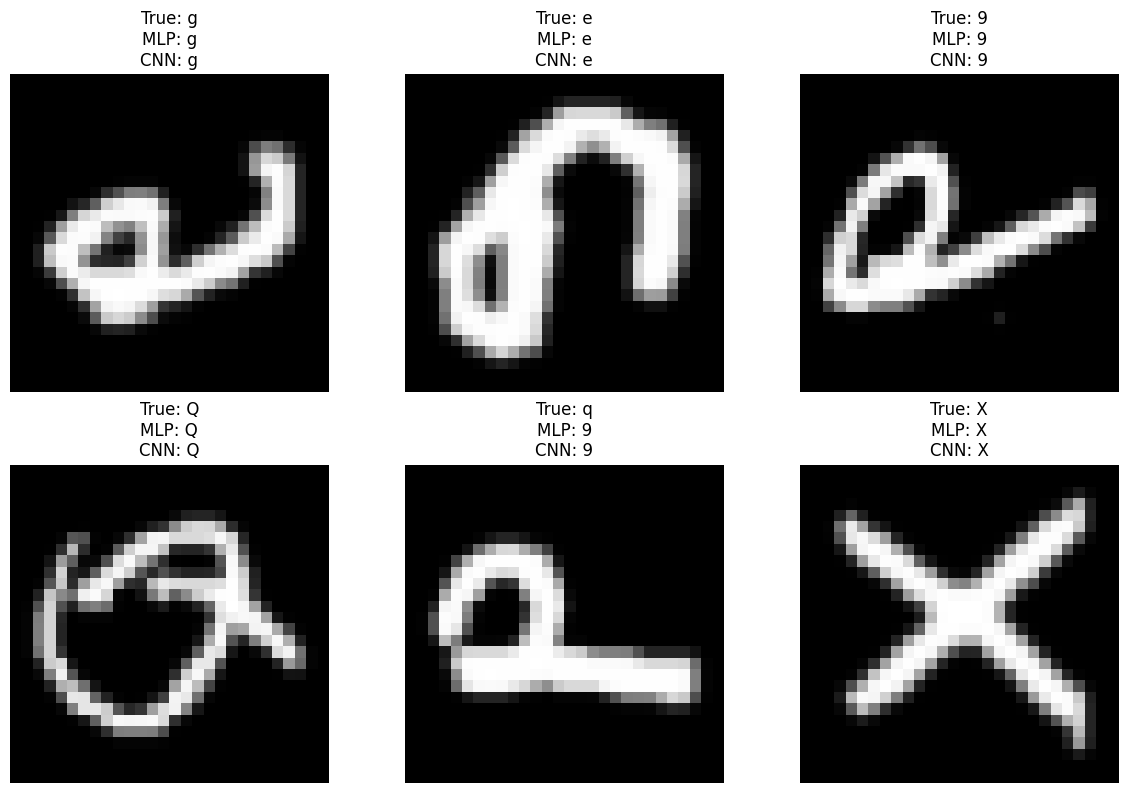

588/588 [==============================] - 1s 2ms/step


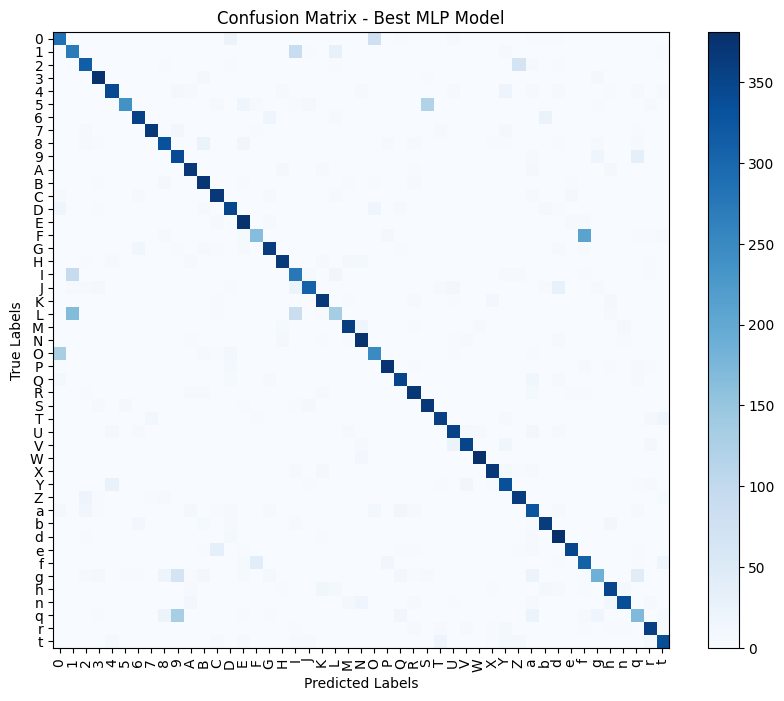

588/588 [==============================] - 2s 4ms/step


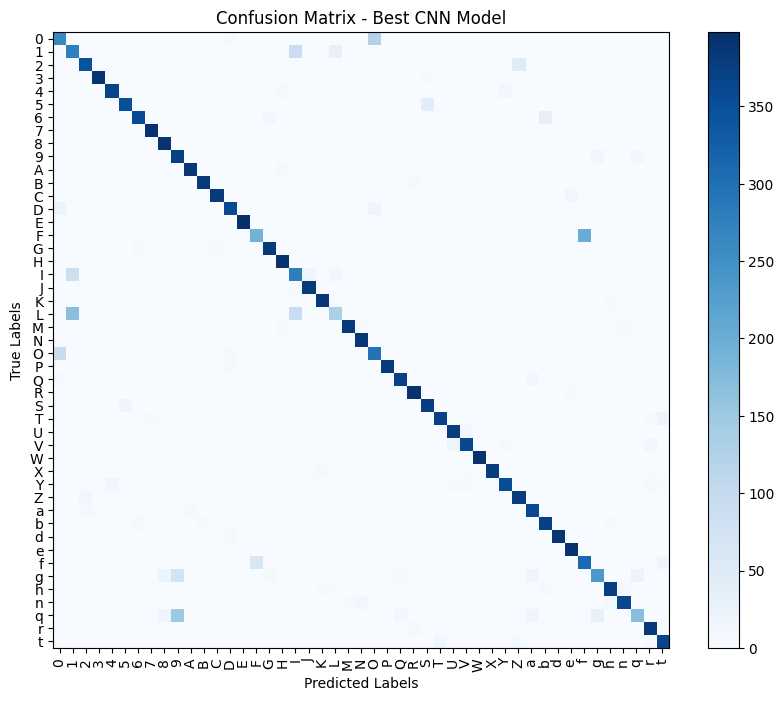

Performance Summary:
MLP Model:
Accuracy: 0.8215
Precision: 0.8277
Recall: 0.8215
F1 Score: 0.8181

CNN Model:
Accuracy: 0.8756
Precision: 0.8804
Recall: 0.8756
F1 Score: 0.8726


In [ ]:
# Step 6: Printing predictions for top 6 samples in the testing dataset
mlp_predictions = mlp_model.predict(X_test[:6])
cnn_predictions = cnn_model.predict(X_test[:6])

print("Predictions for top 6 samples in the testing dataset:")
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"True: {labels[y_test[i].argmax()]}\nMLP: {labels[mlp_predictions[i].argmax()]}\nCNN: {labels[cnn_predictions[i].argmax()]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Plotting confusion matrix for MLP model
mlp_y_true = np.argmax(y_test, axis=1)
mlp_y_pred = np.argmax(mlp_model.predict(X_test), axis=1)
mlp_conf_matrix = confusion_matrix(mlp_y_true, mlp_y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(mlp_conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Best MLP Model')
plt.show()

# Plotting confusion matrix for CNN model
cnn_y_true = np.argmax(y_test, axis=1)
cnn_y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
cnn_conf_matrix = confusion_matrix(cnn_y_true, cnn_y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(cnn_conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Best CNN Model')
plt.show()

# Step 6: Summarized the performance of MLP and CNN models
print("Performance Summary:")
print("MLP Model:")
print(f"Accuracy: {mlp_model.evaluate(X_test, y_test, verbose=0)[1]:.4f}")
print(f"Precision: {precision_score(mlp_y_true, mlp_y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(mlp_y_true, mlp_y_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(mlp_y_true, mlp_y_pred, average='weighted'):.4f}")

print("\nCNN Model:")
print(f"Accuracy: {cnn_model.evaluate(X_test, y_test, verbose=0)[1]:.4f}")
print(f"Precision: {precision_score(cnn_y_true, cnn_y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(cnn_y_true, cnn_y_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(cnn_y_true, cnn_y_pred, average='weighted'):.4f}")